In [8]:
import pandas as pd
import numpy as np
import ast
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

In [9]:
gemma4b_df = pd.read_csv("data/gemma4b-test_results.csv")
llama3b_df = pd.read_csv("data/llama3b-test_results.csv")
llama1b_df = pd.read_csv("data/llama1b-test_results.csv")
gemma2b_df = pd.read_csv("data/gemma2b-test_results.csv")
gemma270m_df = pd.read_csv("data/gemma270m-test_results.csv")

In [10]:
def simple_parse_list(s):
    """Simple parser for your specific format."""
    # Remove outer brackets
    s = s.strip('[]')
    
    # Use regex to find all items (quoted or unquoted)
    pattern = r"'([^']*)'|\"([^\"]*)\"|([^,]+)"
    matches = re.findall(pattern, s)
    
    # Extract non-empty groups from matches
    items = []
    for match in matches:
        item = next((group.strip() for group in match if group.strip()), None)
        if item:
            items.append(item)
    
    return items

def parse_triple(triple):
    """Parse a triple into entity, relation, value components."""
    parts = triple.split(' | ')
    if len(parts) != 3:
        return None, None, None
    return parts[0].strip(), parts[1].strip(), parts[2].strip()

def normalize_value(value):
    """Normalize values by removing units and converting numbers."""
    import re
    
    # Remove units in parentheses
    value = re.sub(r'\s*\([^)]+\)\s*', '', value)
    
    # Try to convert to float for numeric comparison
    try:
        return float(value)
    except:
        return value.strip().lower()

def fuzzy_triple_match_advanced(gt_triple, pred_triple, 
                               entity_threshold=90, 
                               relation_threshold=70, 
                               value_threshold=85):
    """Advanced fuzzy matching that compares each component separately."""
    
    gt_entity, gt_relation, gt_value = parse_triple(gt_triple)
    pred_entity, pred_relation, pred_value = parse_triple(pred_triple)
    
    if None in [gt_entity, gt_relation, gt_value, pred_entity, pred_relation, pred_value]:
        return False, 0
    
    # Entity matching (should be high threshold)
    entity_score = fuzz.ratio(gt_entity, pred_entity)
    entity_match = entity_score >= entity_threshold
    
    # Relation matching (can be more flexible)
    relation_score = fuzz.ratio(gt_relation, pred_relation)
    relation_match = relation_score >= relation_threshold
    
    # Value matching (handle numeric vs string)
    gt_norm = normalize_value(gt_value)
    pred_norm = normalize_value(pred_value)
    
    if isinstance(gt_norm, float) and isinstance(pred_norm, float):
        # Numeric comparison with tolerance
        value_match = abs(gt_norm - pred_norm) / max(abs(gt_norm), abs(pred_norm), 1) < 0.1
        value_score = 100 if value_match else 0
    else:
        # String comparison
        value_score = fuzz.ratio(str(gt_norm), str(pred_norm))
        value_match = value_score >= value_threshold
    
    # Overall match requires all components to match
    overall_match = entity_match and relation_match and value_match
    overall_score = (entity_score + relation_score + value_score) / 3
    
    return overall_match, {
        'overall_score': overall_score,
        'entity_score': entity_score,
        'relation_score': relation_score,
        'value_score': value_score,
        'components_match': {
            'entity': entity_match,
            'relation': relation_match,
            'value': value_match
        }
    }

def fuzzy_evaluation_advanced(ground_truth, predictions, 
                            entity_threshold=90, 
                            relation_threshold=70, 
                            value_threshold=85):
    """Advanced fuzzy evaluation with component-wise matching."""
    
    matched_pairs = []
    used_predictions = set()
    
    for gt_triple in ground_truth:
        best_match = None
        best_score = 0
        best_pred_idx = -1
        best_details = None
        
        for i, pred_triple in enumerate(predictions):
            if i in used_predictions:
                continue
                
            is_match, details = fuzzy_triple_match_advanced(
                gt_triple, pred_triple, 
                entity_threshold, relation_threshold, value_threshold
            )
            
            if is_match and details['overall_score'] > best_score:
                best_match = pred_triple
                best_score = details['overall_score']
                best_pred_idx = i
                best_details = details
        
        if best_match:
            matched_pairs.append({
                'gt_triple': gt_triple,
                'pred_triple': best_match,
                'score_details': best_details
            })
            used_predictions.add(best_pred_idx)
    
    correct = len(matched_pairs)
    precision = correct / len(predictions) if predictions else 0
    recall = correct / len(ground_truth) if ground_truth else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct': correct,
        'total_pred': len(predictions),
        'total_gt': len(ground_truth),
        'matched_pairs': matched_pairs,
        'thresholds': {
            'entity': entity_threshold,
            'relation': relation_threshold,
            'value': value_threshold
        }
    }

In [11]:
def evaluate_dataframe_fuzzy(df):
    """Iterate over DataFrame and evaluate each row with fuzzy matching."""
    
    results = []
    
    print(f"Total rows to process: {len(df)}")
    
    
    for i in range(len(df)):
        try:
            # Parse ground truth and predictions
            ground_truth = simple_parse_list(df['output'].values[i])
            predictions = simple_parse_list(df['generated_response'].values[i])
            
            # Apply fuzzy evaluation
            result = fuzzy_evaluation_advanced(
                ground_truth, 
                predictions, 
                entity_threshold=90, 
                relation_threshold=80, 
                value_threshold=80,
            )
            
            # Store result with row information
            result['row_index'] = i
            result['ground_truth'] = ground_truth
            result['predictions'] = predictions
            results.append(result)
            
            # Print progress every 10 rows
            # if (i + 1) % 10 == 0:
            #     print(f"Processed {i + 1}/{len(df)} rows...")
            
        except Exception as e:
            print(f"Error processing row {i}: {e}")
            print(f"Ground truth: {df['output'].values[i]}")
            print(f"Predictions: {df['generated_response'].values[i]}")
            continue
    
    return results

In [12]:
def analyze_results(results):
    """Analyze and summarize the evaluation results."""
    
    if not results:
        print("No results to analyze!")
        return
    
    print("\n" + "="*80)
    print("EVALUATION SUMMARY")
    print("="*80)
    
    # Basic statistics
    total_rows = len(results)
    avg_f1 = sum(r['f1'] for r in results) / total_rows
    avg_precision = sum(r['precision'] for r in results) / total_rows
    avg_recall = sum(r['recall'] for r in results) / total_rows
    
    print(f"Total evaluated rows: {total_rows}")
    print(f"Average F1 Score: {avg_f1:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    
    
    
    # Distribution analysis
    f1_scores = [r['f1'] for r in results]
    perfect_matches = sum(1 for f1 in f1_scores if f1 == 1.0)
    zero_matches = sum(1 for f1 in f1_scores if f1 == 0.0)
    
    print(f"\nScore Distribution:")
    print(f"Perfect matches (F1=1.0): {perfect_matches} ({perfect_matches/total_rows*100:.1f}%)")
    print(f"No matches (F1=0.0): {zero_matches} ({zero_matches/total_rows*100:.1f}%)")
    
    # Show best and worst examples
    print(f"\n" + "="*50)
    print("BEST PERFORMING EXAMPLES (Top 3)")
    print("="*50)
    
    best_results = sorted(results, key=lambda x: x['f1'], reverse=True)[:3]
    for i, result in enumerate(best_results, 1):
        print(f"\n--- Best Example #{i} (Row {result['row_index']}) ---")
        print(f"F1 Score: {result['f1']:.3f}")
        print(f"Ground Truth: {result['ground_truth']}")
        print(f"Predictions: {result['predictions']}")
    
    print(f"\n" + "="*50)
    print("WORST PERFORMING EXAMPLES (Bottom 3)")
    print("="*50)
    
    worst_results = sorted(results, key=lambda x: x['f1'])[:3]
    for i, result in enumerate(worst_results, 1):
        print(f"\n--- Worst Example #{i} (Row {result['row_index']}) ---")
        print(f"F1 Score: {result['f1']:.3f}")
        print(f"Ground Truth: {result['ground_truth']}")
        print(f"Predictions: {result['predictions']}")

    return avg_f1, avg_precision, avg_recall
        



In [13]:
evaluation_data = {}
for model in ["gemma270m", "gemma2b", "gemma4b", "llama1b", "llama3b"]:
    print(f"\n\nEvaluating model: {model}")
    if model == "gemma270m":
        df = gemma270m_df
    elif model == "gemma2b":
        df = gemma2b_df
    elif model == "gemma4b":
        df = gemma4b_df
    elif model == "llama1b":
        df = llama1b_df
    elif model == "llama3b":
        df = llama3b_df
    else:
        print(f"Unknown model: {model}")
        continue
    
    evaluation_results = evaluate_dataframe_fuzzy(df)
    scores =  analyze_results(evaluation_results)
    evaluation_data[model] = scores



Evaluating model: gemma270m
Total rows to process: 178

EVALUATION SUMMARY
Total evaluated rows: 178
Average F1 Score: 0.153
Average Precision: 0.159
Average Recall: 0.164

Score Distribution:
Perfect matches (F1=1.0): 6 (3.4%)
No matches (F1=0.0): 114 (64.0%)

BEST PERFORMING EXAMPLES (Top 3)

--- Best Example #1 (Row 44) ---
F1 Score: 1.000
Ground Truth: ['Liselotte_Grschebina | nationality | Israel']
Predictions: ['Liselotte_Grschebina | nationality | Israel']

--- Best Example #2 (Row 108) ---
F1 Score: 1.000
Ground Truth: ['Hypermarcas | numberOfEmployees | 10252']
Predictions: ['Hypermarcas | numberOfEmployees | 10252']

--- Best Example #3 (Row 120) ---
F1 Score: 1.000
Ground Truth: ['Morelos | leader | Adrián_Rivera_Pérez']
Predictions: ['Morelos | leader | Adriana_Riveros_Pérez']

WORST PERFORMING EXAMPLES (Bottom 3)

--- Worst Example #1 (Row 0) ---
F1 Score: 0.000
Ground Truth: ['Brandon_Carter | knownFor | Doomsday_argument']
Predictions: ['Brandon_Carter | occupation | D

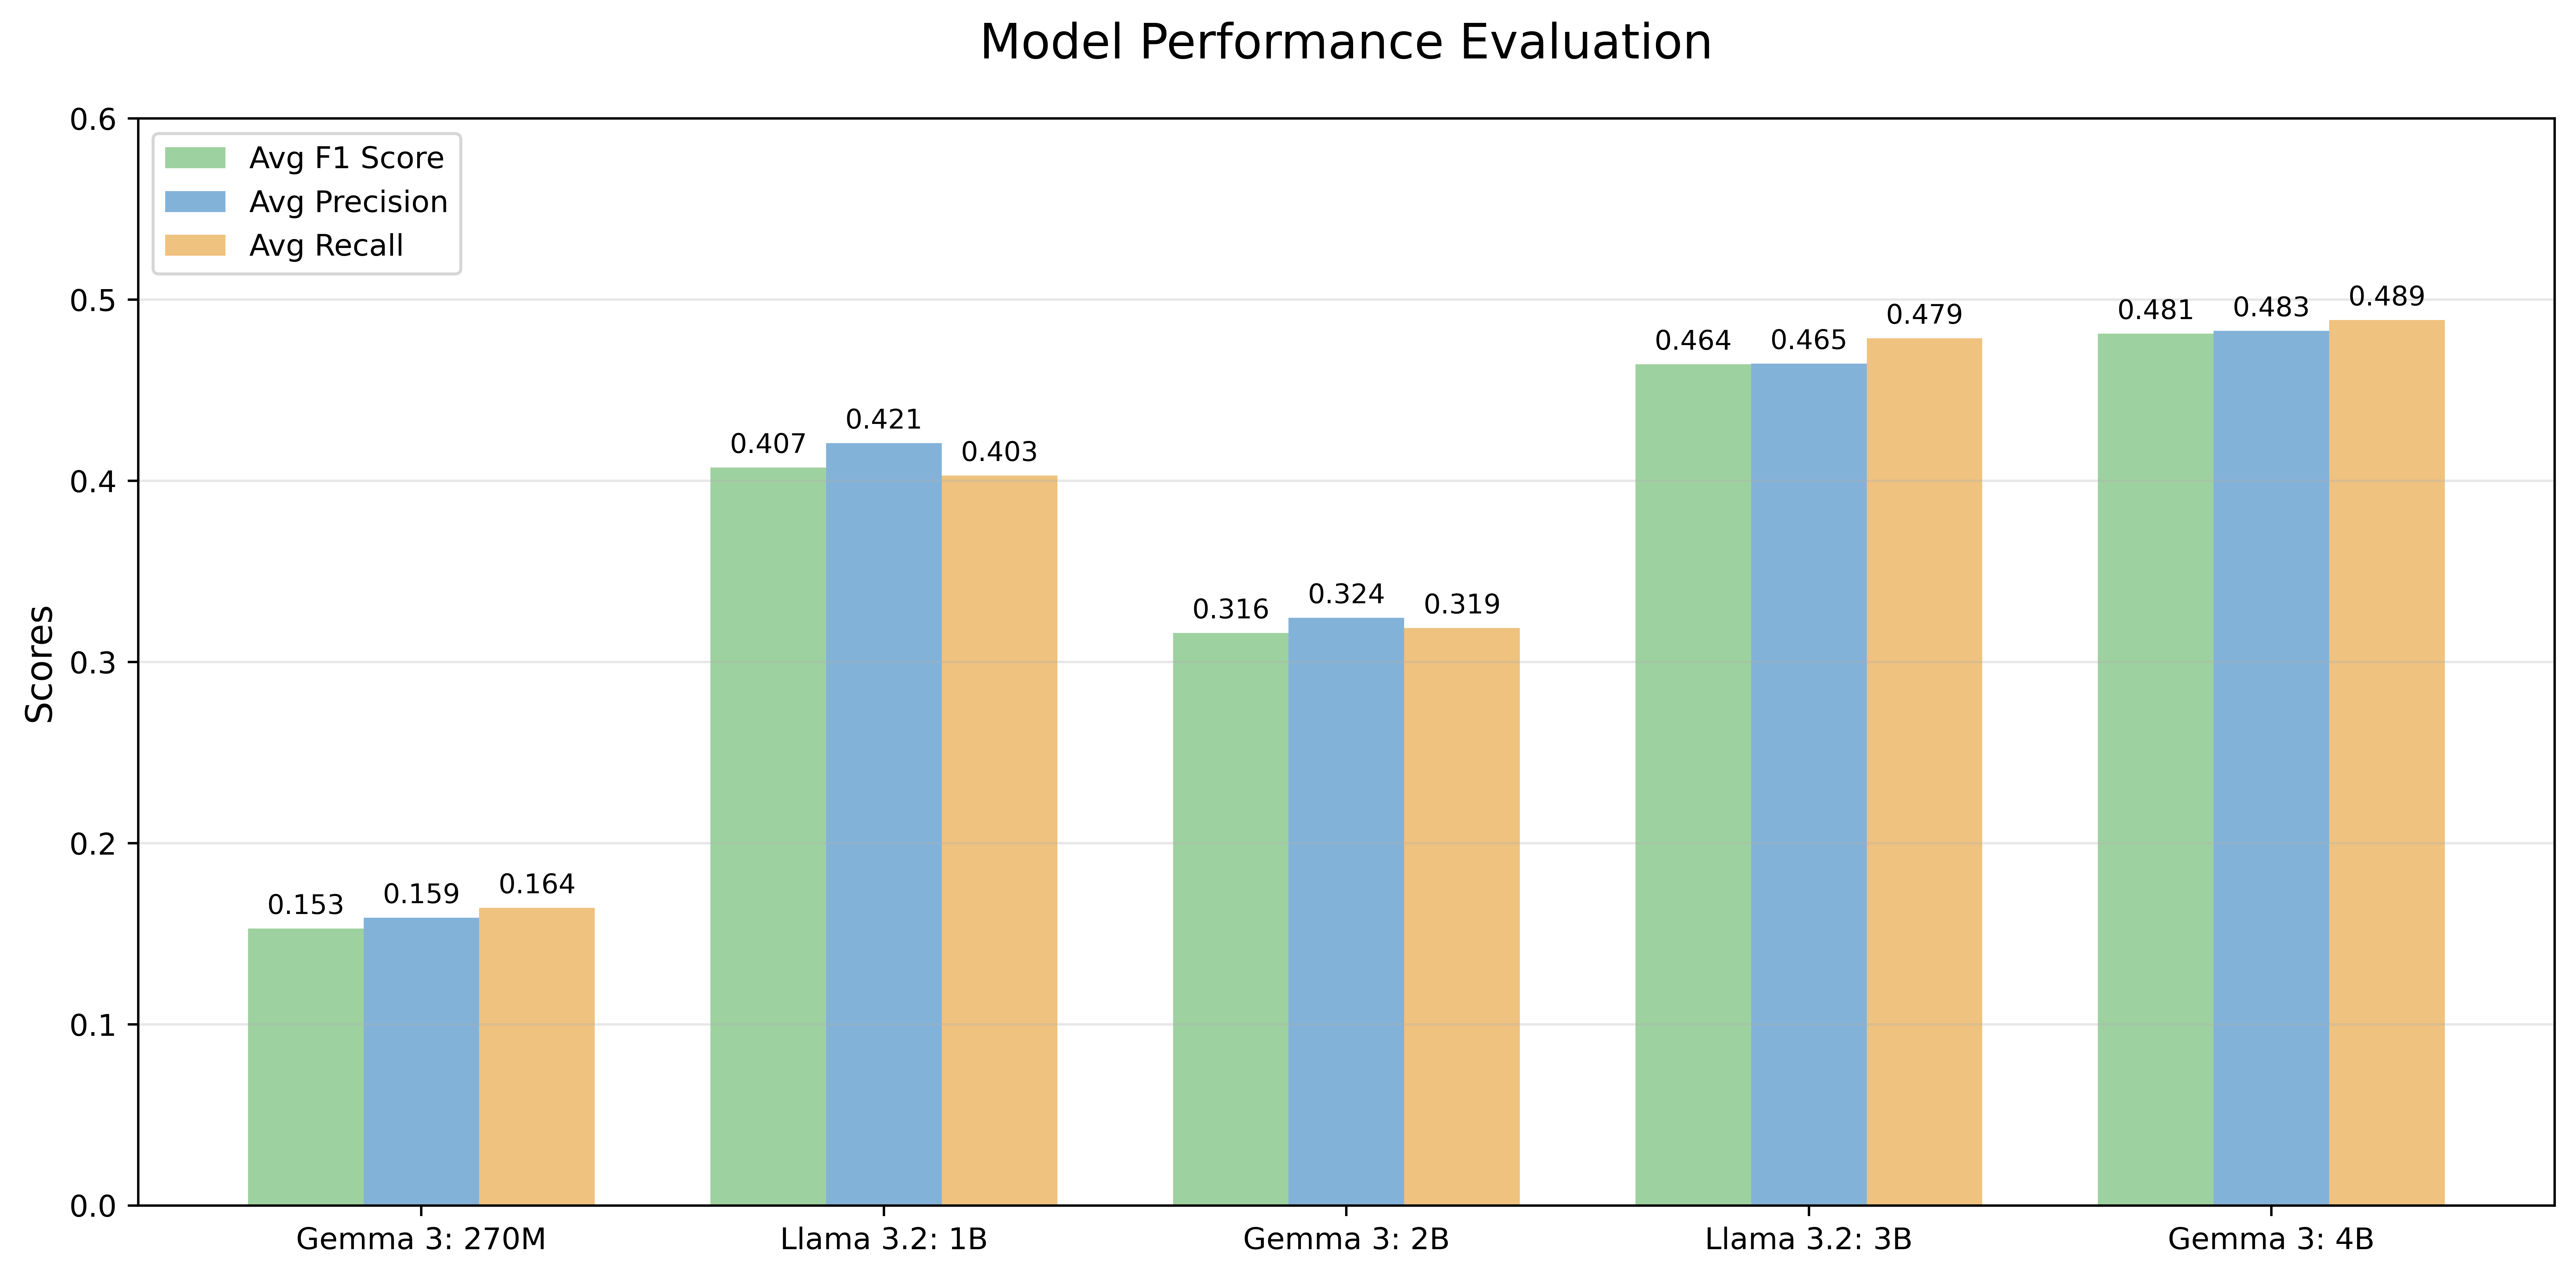

In [20]:
import matplotlib.pyplot as plt
import numpy as np

model_mapping = {
    'gemma270m': 'Gemma 3: 270M',
    'llama1b': 'Llama 3.2: 1B',
    'gemma2b': 'Gemma 3: 2B',
    'llama3b': 'Llama 3.2: 3B',
    'gemma4b': 'Gemma 3: 4B'
}


ordered_model_keys = ['gemma270m', 'llama1b', 'gemma2b', 'llama3b', 'gemma4b']

models = [model_mapping[key] for key in ordered_model_keys]
f1_scores = [evaluation_data[key][0] for key in ordered_model_keys]
precision_scores = [evaluation_data[key][1] for key in ordered_model_keys]
recall_scores = [evaluation_data[key][2] for key in ordered_model_keys]

x = np.arange(len(models)) 
width = 0.25  

fig, ax = plt.subplots(figsize=(12, 6), dpi=700)

rects1 = ax.bar(x - width, f1_scores, width, label='Avg F1 Score', color="#9ED1A0")
rects2 = ax.bar(x, precision_scores, width, label='Avg Precision', color="#83B2D9")
rects3 = ax.bar(x + width, recall_scores, width, label='Avg Recall', color="#EFC27F")

ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Performance Evaluation', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend(loc='upper left')
ax.set_ylim(0, 0.6)  
ax.grid(True, alpha=0.3, axis='y')

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()
plt.show()

In [15]:
evaluation_data

{'gemma270m': (0.1528401886360696, 0.15887781970987508, 0.16432827472153314),
 'gemma2b': (0.3160564288066791, 0.32445225237556036, 0.31880928060703345),
 'gemma4b': (0.4812667357611178, 0.4827531475827073, 0.4887245245391311),
 'llama1b': (0.4074216965109927, 0.42079563694732236, 0.4029986867065519),
 'llama3b': (0.46443332010604893, 0.46475879514010043, 0.4786991098788851)}